In [ ]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install evalml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


import plotly.graph_objects as go
from nltk.corpus import stopwords

In [ ]:
df = pd.read_csv("US_Accidents_March23.csv")
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.010,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.010,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.010,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.010,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.010,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,A-7777757,Source1,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.99888,-117.37094,0.543,...,False,False,False,False,False,False,Day,Day,Day,Day
7728390,A-7777758,Source1,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.76555,-117.15363,0.338,...,False,False,False,False,False,False,Day,Day,Day,Day
7728391,A-7777759,Source1,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.77740,-117.85727,0.561,...,False,False,False,False,False,False,Day,Day,Day,Day
7728392,A-7777760,Source1,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403020,33.98311,-118.39565,0.772,...,False,False,False,False,False,False,Day,Day,Day,Day


# <div class="alert alert-block alert-info">Data Preprocessing</div>

# Time conversion

In [ ]:
# some timestamps include additional fractional seconds (.000000000), which pd.to_datetime cannot handle in its default behavior.
# check what the problematic timestamps look like.
problem_rows = df["Start_Time"][~df["Start_Time"].str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$")]
print(problem_rows)

3639775    2017-07-23 04:21:01.000000000
3639776    2017-07-23 05:18:46.000000000
3639777    2017-07-23 05:36:01.000000000
3639778    2017-07-23 08:36:01.000000000
3639779    2017-07-23 11:02:16.000000000
                       ...              
6834080    2020-11-20 11:09:00.000000000
6834081    2020-11-19 17:58:00.000000000
6834082    2020-11-03 15:59:00.000000000
6834083    2020-11-17 01:29:12.000000000
6834084    2020-11-25 01:24:00.000000000
Name: Start_Time, Length: 743166, dtype: object


In [ ]:
# this is to handle different formats
# it provides a custom format "string" to "pd.to_datetime"
df["Start_Time"] = pd.to_datetime(df["Start_Time"].str.split('.').str[0], format="%Y-%m-%d %H:%M:%S")

In [ ]:
# To decompose the Start_Time feature in year, month, day, weekday, hour and minute, in order to feed them to the models.

# Cast Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"])

# Extract year, month, weekday and day
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Weekday"] = df["Start_Time"].dt.weekday
df["Day"] = df["Start_Time"].dt.day

# Extract hour and minute
df["Hour"] = df["Start_Time"].dt.hour
df["Minute"] = df["Start_Time"].dt.minute

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,Night,Night,Night,Night,2016,2,0,8,5,46
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,Night,Night,Night,Day,2016,2,0,8,6,7
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,Night,Night,Day,Day,2016,2,0,8,6,49
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,Night,Day,Day,Day,2016,2,0,8,7,23
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,Day,Day,Day,Day,2016,2,0,8,7,39


# Feature selection

In [ ]:
# drop some features we don't need
features_to_drop = ["ID", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
df_filtered = df.drop(features_to_drop, axis=1)
df_filtered.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,3,39.865147,-84.058723,0.01,Dayton,36.9,91.0,29.68,10.0,Calm,...,False,False,False,Night,2016,2,0,8,5,46
1,2,39.928059,-82.831184,0.01,Reynoldsburg,37.9,100.0,29.65,10.0,Calm,...,False,False,False,Night,2016,2,0,8,6,7
2,2,39.063148,-84.032608,0.01,Williamsburg,36.0,100.0,29.67,10.0,SW,...,False,False,True,Night,2016,2,0,8,6,49
3,3,39.747753,-84.205582,0.01,Dayton,35.1,96.0,29.64,9.0,SW,...,False,False,False,Day,2016,2,0,8,7,23
4,2,39.627781,-84.188354,0.01,Dayton,36.0,89.0,29.65,6.0,SW,...,False,False,True,Day,2016,2,0,8,7,39


# Drop duplicates¶

In [ ]:
# check if there are some duplicates in the dataset, then drop them.
print("Number of rows:", len(df_filtered.index))
df_filtered.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(df_filtered.index))

Number of rows: 7728394
Number of rows after drop of duplicates: 7302748


# Handle erroneous and missing values

In [ ]:
print(df_filtered.columns)

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'City',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Year', 'Month',
       'Weekday', 'Day', 'Hour', 'Minute'],
      dtype='object')


In [ ]:
# 1. analyze Pressure and Visibility

In [ ]:
df_filtered[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,7170841.00,7136410.00
mean,29.55,9.09
std,1.00,2.70
min,0.00,0.00
25%,29.38,10.00
50%,29.86,10.00
75%,30.03,10.00
max,58.63,140.00


In [ ]:
# We can see that the minimum value is 0, meaning that some records are missing them and replaced them by putting zeros.
# For this reason, we can drop the records with missing values for these two columns.
df_filtered = df_filtered[df_filtered["Pressure(in)"] != 0]
df_filtered = df_filtered[df_filtered["Visibility(mi)"] != 0]
df_filtered[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,7163822.00,7129377.00
mean,29.55,9.10
std,1.00,2.68
min,0.02,0.06
25%,29.38,10.00
50%,29.86,10.00
75%,30.03,10.00
max,58.63,140.00


In [ ]:
# 2. analyze weather conditions

In [ ]:
unique_weather = df_filtered["Weather_Condition"].unique()

print(len(unique_weather))
print(unique_weather)

145
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light Fog' 'Sand'
 'Sn

In [ ]:
# we can see that there are lots of weather condition, so it's better to reduce the number of unique conditions.
# so we can replace them with a more generic description:

In [ ]:
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df_filtered.loc[df_filtered["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(df_filtered["Weather_Condition"].unique())

['Rain' 'Cloudy' 'Snow' 'Fog' 'Clear' nan 'Smoke' 'Thunderstorm' 'Sand'
 'Windy' 'Hail' 'Tornado']


In [ ]:
# 3. analyze Wind_Direction

In [ ]:
df_filtered["Wind_Direction"].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [ ]:
# we can group the values of "wind_condition", like we did with Weather_Condition:
df_filtered.loc[df_filtered["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
df_filtered.loc[df_filtered["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
df_filtered.loc[df_filtered["Wind_Direction"] == "East", "Wind_Direction"] = "E"
df_filtered.loc[df_filtered["Wind_Direction"] == "North", "Wind_Direction"] = "N"
df_filtered.loc[df_filtered["Wind_Direction"] == "South", "Wind_Direction"] = "S"
df_filtered.loc[df_filtered["Wind_Direction"] == "West", "Wind_Direction"] = "W"

df_filtered["Wind_Direction"] = df_filtered["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

df_filtered["Wind_Direction"].unique()

array(['Calm', 'SW', 'NW', 'W', 'NE', 'S', 'N', 'Variable', 'SE', 'E',
       nan], dtype=object)

In [ ]:
# 4. analyze the missing values

In [ ]:
# check the missing values in each feature
df_filtered.isna().sum()

Severity                   0
Start_Lat                  0
Start_Lng                  0
Distance(mi)               0
City                     241
Temperature(F)        153598
Humidity(%)           163111
Pressure(in)          131892
Visibility(mi)        166337
Wind_Direction        162899
Wind_Speed(mph)       557034
Precipitation(in)    2175773
Weather_Condition     166050
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Civil_Twilight         20784
Year                       0
Month                      0
Weekday                    0
Day                        0
Hour                       0
Minute                     0
dtype: int64

In [ ]:
# For numerical features we can fill the missing features with the mean;

# Since a lot of records do not have information about Precipitation, Year, Month, Weekday, Day, Hour, Minute
# so we can drop those records.

# For categorical features like City, Wind_Direction, Weather_Condition and Civil_Twilight,
# we are going to delete the records with missing informations.

features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
df_filtered[features_to_fill] = df_filtered[features_to_fill].fillna(df_filtered[features_to_fill].mean())

df_filtered.dropna(inplace=True)
df_filtered.isna().sum()

# Now there isn't any missing value in our dataset

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

# Handle unbalanced data¶

In [ ]:
# The severity attribute is very unbalanced,
# the number of accident with the severity 1 is very small, but the number of accident with severity 2 and 3 is much higher.
severity_counts = df_filtered["Severity"].value_counts()
severity_counts

Severity
2    5568583
3    1254203
4     188903
1      62933
Name: count, dtype: int64

In [ ]:
# So, in order to balance the data, we can undersample all the categories to the number of records of the minority category,
# in this case the severity 1. This still leaves us with a good amount of records for each category

# Size of the minority category (severity = 1)
size = len(df_filtered[df_filtered["Severity"] == 1])

# Create an empty list to collect sampled DataFrames
dfs = []

# Loop through the severity levels (1 to 4 in this case)
for i in range(1, 5):
    S = df_filtered[df_filtered["Severity"] == i]
    dfs.append(S.sample(size, random_state=42))

# Combine all the sampled DataFrames
df_filtered = pd.concat(dfs)

severity_counts = df_filtered["Severity"].value_counts()
severity_counts

Severity
1    62933
2    62933
3    62933
4    62933
Name: count, dtype: int64

# Feature scaling

In [ ]:
# To improve the performance of our models, we can normalize the values of the continuous features.
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Start_Lng','Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
df_filtered[features] = scaler.fit_transform(df_filtered[features])
df_normalized = df_filtered
df_normalized.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
7122085,1,0.522091,0.045711,0.0,San Jose,0.585938,0.612245,0.553797,0.07103,N,...,False,False,True,Day,0.571429,0.272727,0.833333,0.333333,0.521739,0.728814
606651,1,0.622916,0.708839,0.0,Dayton,0.542969,0.632653,0.522679,0.07103,N,...,False,False,True,Day,0.857143,0.363636,0.000000,0.733333,0.347826,0.000000
546971,1,0.581905,0.527424,0.0,Raymore,0.652344,0.836735,0.497890,0.07103,SW,...,False,False,False,Day,0.857143,0.636364,0.000000,0.000000,0.347826,0.067797
591345,1,0.363390,0.747092,0.0,Augusta,0.621094,0.673469,0.526899,0.07103,N,...,False,False,True,Day,0.857143,0.454545,0.666667,0.300000,0.260870,0.915254
7102366,1,0.362336,0.217837,0.0,Phoenix,0.667969,0.153061,0.479958,0.07103,SW,...,False,False,True,Day,0.571429,0.272727,0.500000,0.033333,0.782609,0.237288


# Feature encoding

In [ ]:
# 1. We can encode the categorical features using the method get_dummies()

# Remove city for now, it will be encoded later (because there're too many different values in 'City' feature)
categorical_features = set(["City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

# Convert categorical features to 'category' dtype
for cat in categorical_features:
    df_normalized[cat] = df_normalized[cat].astype("category")

# Subtract "City" from the set and convert to a list
onehot_cols = list(categorical_features - set(["City"]))

# Use pd.get_dummies with the list of columns
df_normalized = pd.get_dummies(df_normalized, columns=onehot_cols, drop_first=True)

df_normalized.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Weather_Condition_Cloudy,Weather_Condition_Fog,Weather_Condition_Hail,Weather_Condition_Rain,Weather_Condition_Sand,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_Thunderstorm,Weather_Condition_Tornado,Weather_Condition_Windy
7122085,1,0.522091,0.045711,0.0,San Jose,0.585938,0.612245,0.553797,0.07103,0.021552,...,False,False,False,False,False,False,False,False,False,False
606651,1,0.622916,0.708839,0.0,Dayton,0.542969,0.632653,0.522679,0.07103,0.030172,...,False,False,False,False,False,False,False,False,False,False
546971,1,0.581905,0.527424,0.0,Raymore,0.652344,0.836735,0.497890,0.07103,0.043103,...,False,False,False,False,False,False,False,False,False,False
591345,1,0.363390,0.747092,0.0,Augusta,0.621094,0.673469,0.526899,0.07103,0.030172,...,False,False,False,False,False,False,False,False,False,False
7102366,1,0.362336,0.217837,0.0,Phoenix,0.667969,0.153061,0.479958,0.07103,0.073276,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 2. encode the boolean values in a numerical form
df_normalized = df_normalized.replace([True, False], [1, 0])
df_normalized.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Weather_Condition_Cloudy,Weather_Condition_Fog,Weather_Condition_Hail,Weather_Condition_Rain,Weather_Condition_Sand,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_Thunderstorm,Weather_Condition_Tornado,Weather_Condition_Windy
7122085,1,0.522091,0.045711,0.0,San Jose,0.585938,0.612245,0.553797,0.07103,0.021552,...,0,0,0,0,0,0,0,0,0,0
606651,1,0.622916,0.708839,0.0,Dayton,0.542969,0.632653,0.522679,0.07103,0.030172,...,0,0,0,0,0,0,0,0,0,0
546971,1,0.581905,0.527424,0.0,Raymore,0.652344,0.836735,0.497890,0.07103,0.043103,...,0,0,0,0,0,0,0,0,0,0
591345,1,0.363390,0.747092,0.0,Augusta,0.621094,0.673469,0.526899,0.07103,0.030172,...,0,0,0,0,0,0,0,0,0,0
7102366,1,0.362336,0.217837,0.0,Phoenix,0.667969,0.153061,0.479958,0.07103,0.073276,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 3. Now, we can work on "City" feature. To reduce the number of features, we can use the BinaryEncoder

binary_encoder = ce.binary.BinaryEncoder()
city_binary_enc = binary_encoder.fit_transform(df_normalized["City"])
city_binary_enc

# The binary encoding requires fewer columns, but the columns are less interpretable than one-hot encoded columns.

,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
7122085,0,0,0,0,0,0,0,0,0,0,0,0,0,1
606651,0,0,0,0,0,0,0,0,0,0,0,0,1,0
546971,0,0,0,0,0,0,0,0,0,0,0,0,1,1
591345,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7102366,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601405,0,1,0,1,1,1,0,0,0,0,1,1,0,0
4091458,0,0,0,0,1,0,0,1,1,0,0,1,0,0
7555426,0,0,1,0,0,1,0,1,1,1,1,0,1,1
3626462,0,1,1,1,0,1,1,1,0,0,1,1,1,0


In [ ]:
# 4. Finally, we can merge the two dataframes and obtain the final dataframe 'df_clean' with the categorical features encoded.

df_clean = pd.concat([df_normalized, city_binary_enc], axis=1).drop("City", axis=1)
df_clean.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
7122085,1,0.522091,0.045711,0.0,0.585938,0.612245,0.553797,0.07103,0.021552,0.0,...,0,0,0,0,0,0,0,0,0,1
606651,1,0.622916,0.708839,0.0,0.542969,0.632653,0.522679,0.07103,0.030172,0.0,...,0,0,0,0,0,0,0,0,1,0
546971,1,0.581905,0.527424,0.0,0.652344,0.836735,0.497890,0.07103,0.043103,0.0,...,0,0,0,0,0,0,0,0,1,1
591345,1,0.363390,0.747092,0.0,0.621094,0.673469,0.526899,0.07103,0.030172,0.0,...,0,0,0,0,0,0,0,1,0,0
7102366,1,0.362336,0.217837,0.0,0.667969,0.153061,0.479958,0.07103,0.073276,0.0,...,0,0,0,0,0,0,0,1,0,1


# <div class="alert alert-block alert-warning">Model</div>

In [ ]:
# Metrics dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

In [ ]:
df_clean, df_test = train_test_split(df_clean, test_size=.2, random_state=42)
print(df_clean.shape, df_test.shape)

(201385, 62) (50347, 62)


# Logistic Regression

In [ ]:
sample = df_clean
X = sample.drop("Severity", axis=1)  # Features
y = sample["Severity"]  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)


In [ ]:
# Define logistic regression model
lr = LogisticRegression(random_state=42, n_jobs=-1)
params = {"solver": ["newton-cg", "sag", "saga"]}
grid = GridSearchCV(lr, params, n_jobs=-1, verbose=5)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_test, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters scores:
{'solver': 'saga'}
Train score: 0.5604920230689017
Validation score: 0.5558295815677966


In [ ]:
# Train the model
lr.fit(X_train, y_train)

# Evaluate model performance
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print("Train score:", train_score)
print("Test score:", test_score)

Train score: 0.5495889167121849
Test score: 0.5452032574152542


In [ ]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.79      0.70     15131
           2       0.46      0.35      0.40     15045
           3       0.51      0.57      0.54     15151
           4       0.54      0.48      0.51     15089

    accuracy                           0.55     60416
   macro avg       0.54      0.54      0.54     60416
weighted avg       0.54      0.55      0.54     60416



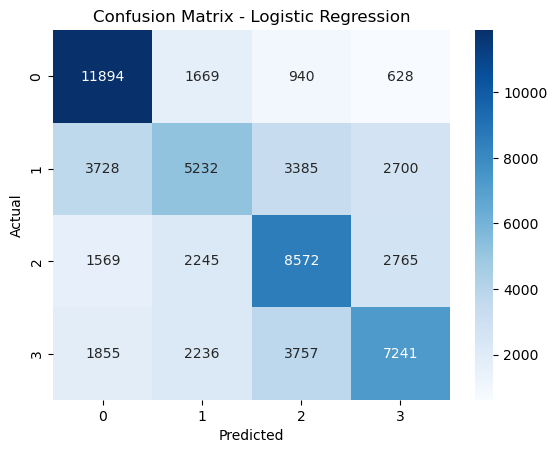

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

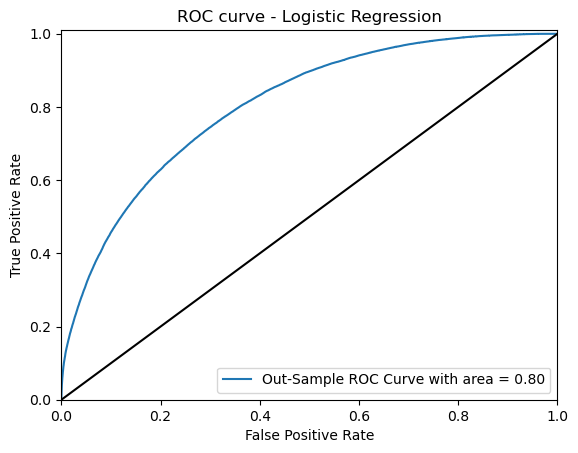

In [ ]:
y_test_binarized = label_binarize(y_test, classes=lr.classes_) # Binarize the labels
y_pred_proba = lr.predict_proba(X_test) # Get probabilities for each class


(fpr, tpr, thresholds) = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel()) # flattens them into 1D arrays

area = auc(fpr, tpr)
plt.plot(fpr, tpr,label="Out-Sample ROC Curve with area = %1.2f"%area, color='tab:blue')
plt.plot([0, 1], [0, 1], 'k')  # Diagonal line
plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.legend(loc="lower right")
plt.show()

# averages the auc for all severity classes

# Decision Tree

In [ ]:
sample = df_clean
X = sample.drop("Severity", axis=1)  # Features
y = sample["Severity"]  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (140969, 61) (140969,)
Test set shape: (60416, 61) (60416,)


In [ ]:
# Initialize Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(dtc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_test, y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters scores:
{'criterion': 'gini', 'max_depth': 10}
Train score: 0.7635650391220765
Validation score: 0.750248278601695


In [ ]:
# Train the model
dtc.fit(X_train, y_train)

# Predictions
y_pred = dtc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.90      0.90     15131
           2       0.57      0.58      0.58     15045
           3       0.64      0.64      0.64     15151
           4       0.68      0.68      0.68     15089

    accuracy                           0.70     60416
   macro avg       0.70      0.70      0.70     60416
weighted avg       0.70      0.70      0.70     60416



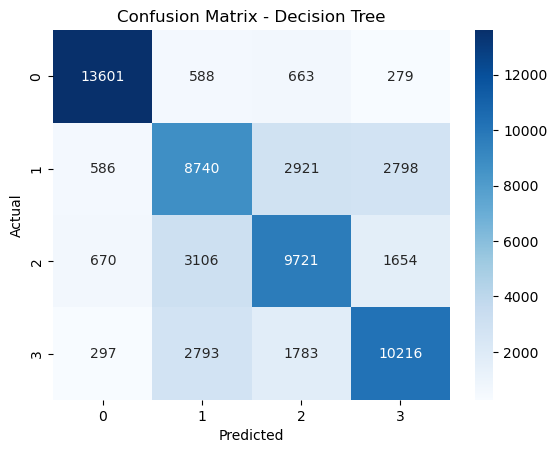

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

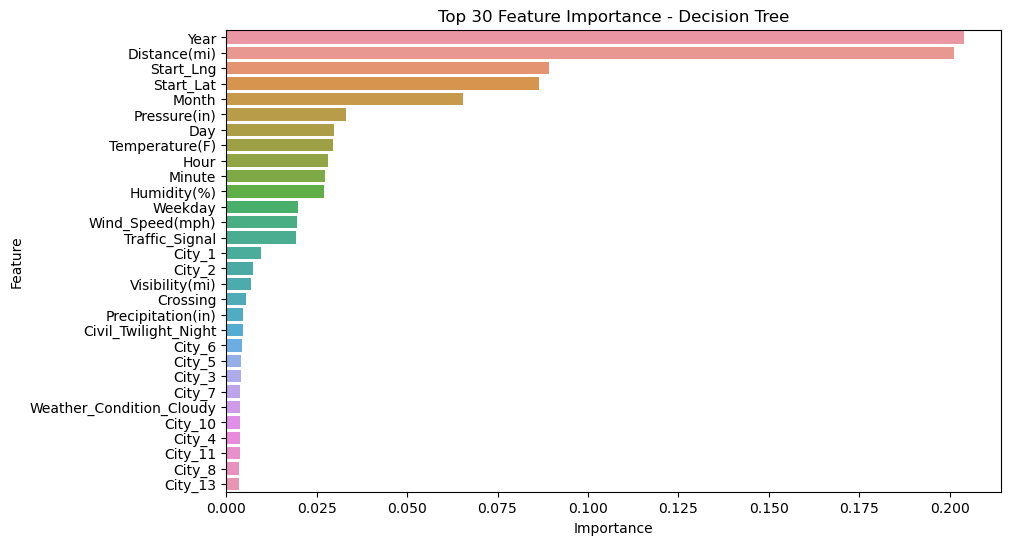

In [ ]:
# Feature importance
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': dtc.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(30))
plt.title("Top 30 Feature Importance - Decision Tree")
plt.show()

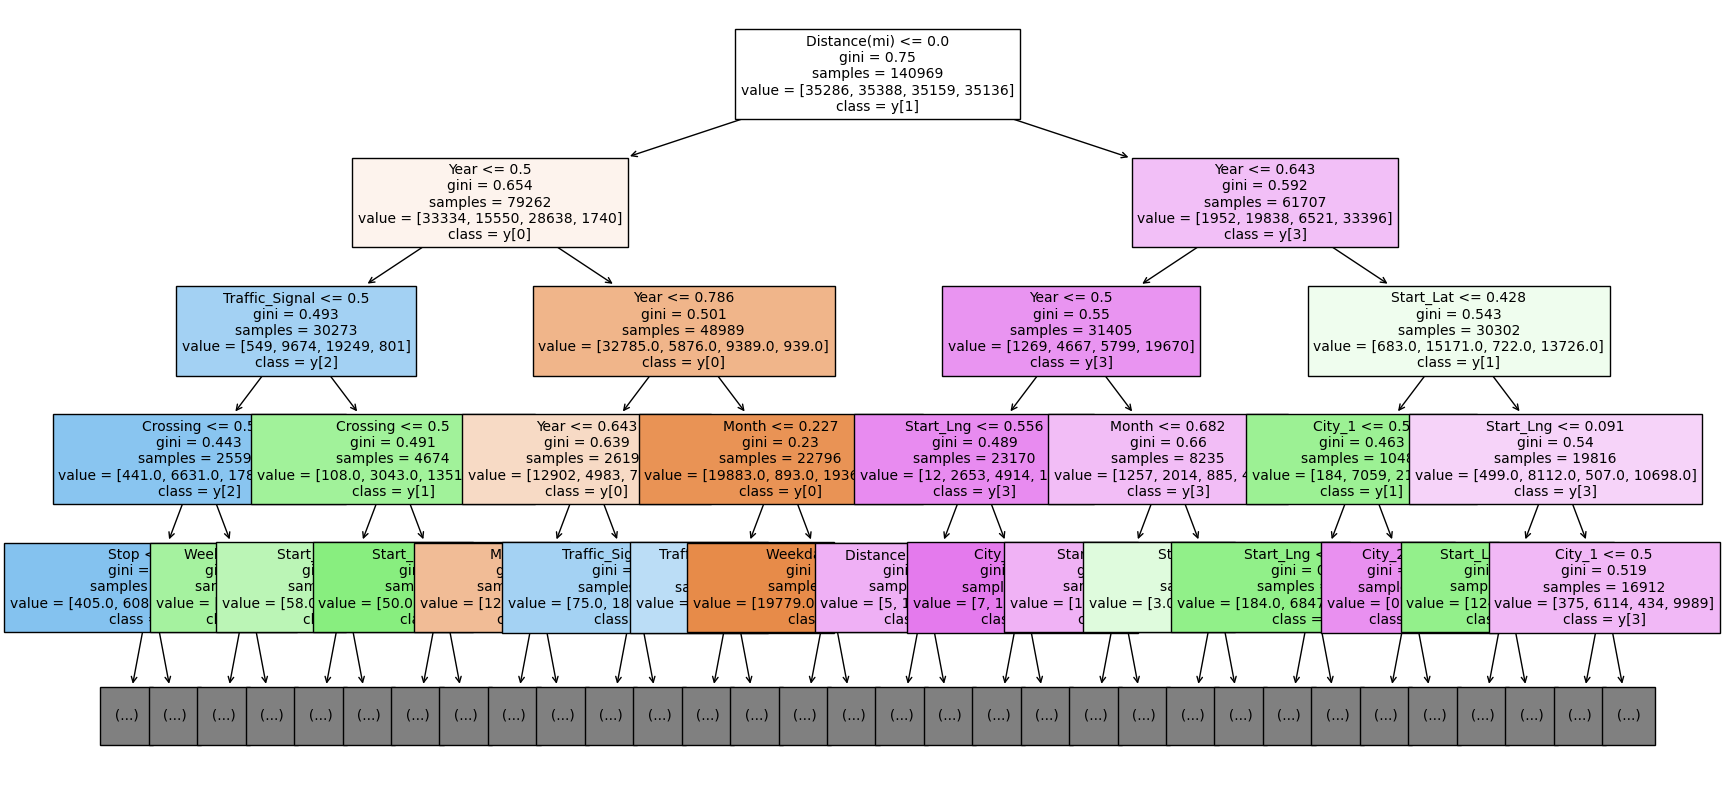

In [ ]:
# Decision Tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train.columns.to_list(), class_names = True, filled=True)
plt.show()

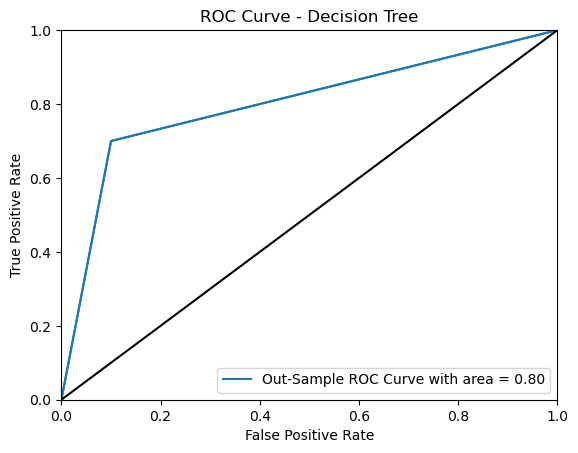

In [ ]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=dtc.classes_) # Binarize the labels
y_pred_proba = dtc.predict_proba(X_test) # Get probabilities for each class

(fpr, tpr, thresholds) = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())

area = auc(fpr,tpr)
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area, color='tab:blue')
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()


# Random Forest

In [ ]:
y_sample = df_clean["Severity"]
X_sample = df_clean.drop("Severity", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(151038, 61) (151038,)
(50347, 61) (50347,)


In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
parameters = [{"n_estimators": [50, 100, 200, 500], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(rfc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_test, y_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters scores:
{'max_depth': 30, 'n_estimators': 500}
Train score: 0.9990929434976629
Validation score: 0.7745247979025562


In [ ]:
rfc.fit(X_train, y_train)
print("Train score:", rfc.score(X_train, y_train))
print("Test score:", rfc.score(X_test, y_test))

Train score: 0.9995497821740225
Test score: 0.7719625796969035


In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.94      0.92     12665
           2       0.72      0.58      0.64     12487
           3       0.73      0.73      0.73     12565
           4       0.72      0.83      0.77     12630

    accuracy                           0.77     50347
   macro avg       0.77      0.77      0.77     50347
weighted avg       0.77      0.77      0.77     50347



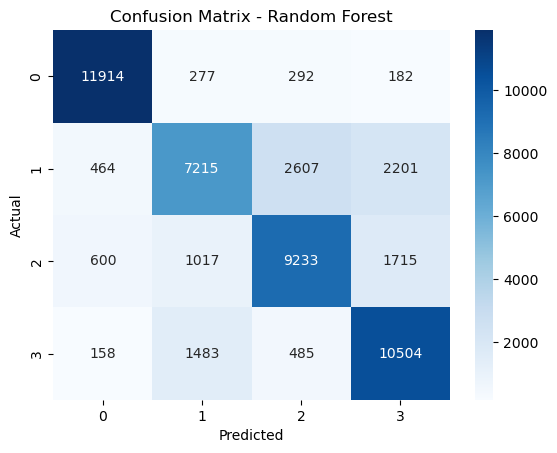

In [ ]:
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

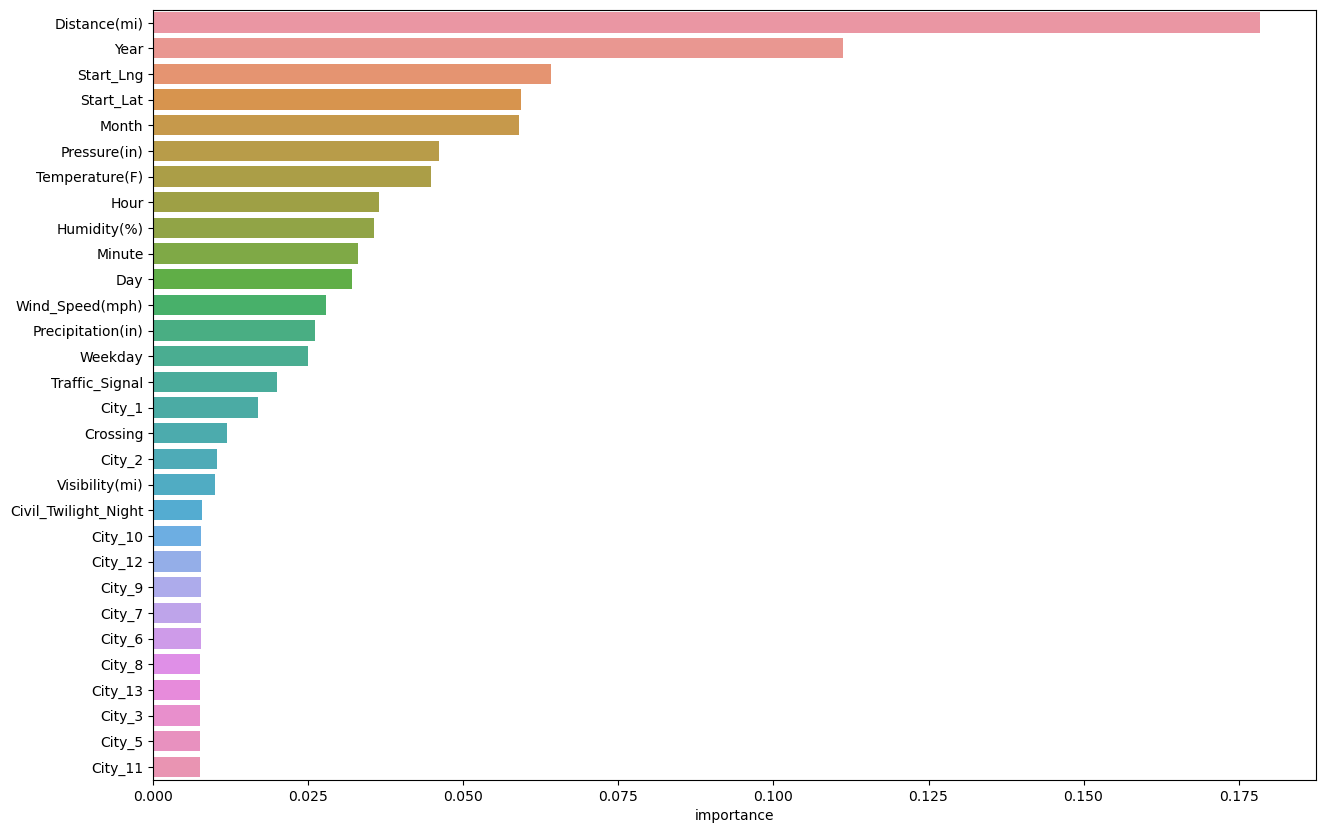

In [ ]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

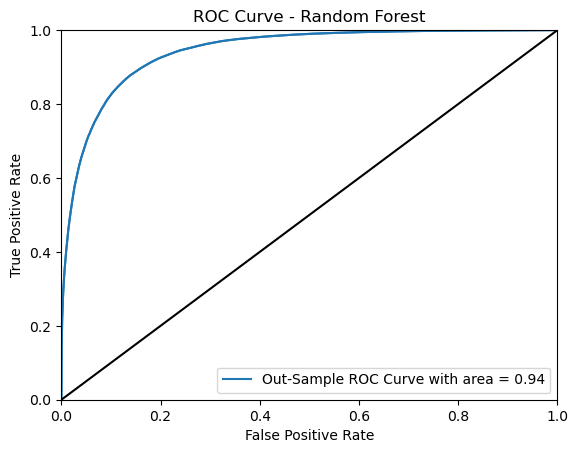

In [ ]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=rfc.classes_) # Binarize the labels
y_pred_proba = rfc.predict_proba(X_test) # Get probabilities for each class

(fpr, tpr, thresholds) = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())

area = auc(fpr,tpr)
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area, color='tab:blue')
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()


# Naive Bayes - Bernoulli

In [ ]:
y_sample = df_clean["Severity"]
X_sample = df_clean.drop("Severity", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(151038, 61) (151038,)
(50347, 61) (50347,)


In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [ ]:
y_pred = bnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.77      0.70     12665
           2       0.46      0.29      0.35     12487
           3       0.57      0.54      0.56     12565
           4       0.59      0.72      0.65     12630

    accuracy                           0.58     50347
   macro avg       0.57      0.58      0.56     50347
weighted avg       0.57      0.58      0.57     50347



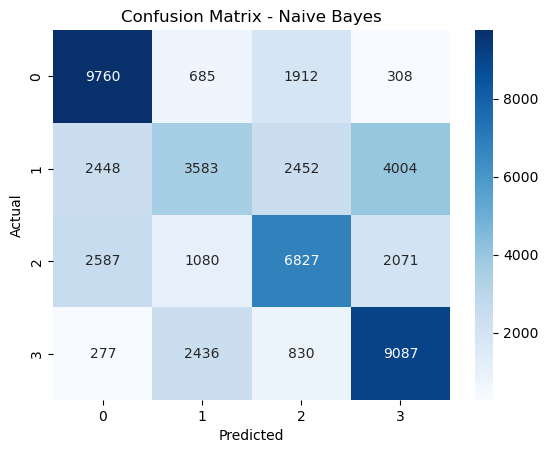

In [ ]:
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# rows = actual severity
# columns = predicted severity

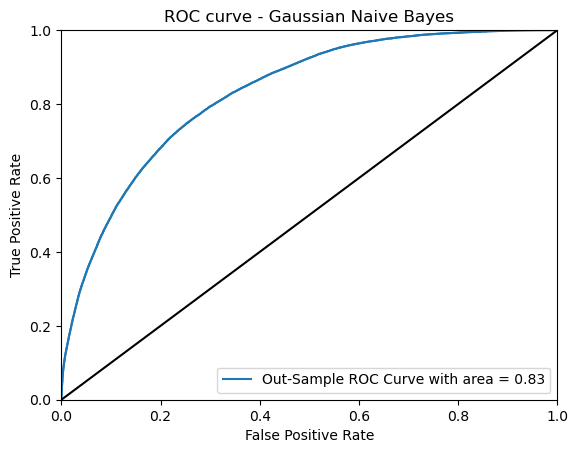

In [ ]:
y_test_binarized = label_binarize(y_test, classes=bnb.classes_) # Binarize the labels
y_pred_proba = bnb.predict_proba(X_test) # Get probabilities for each class


(fpr, tpr, thresholds) = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())

area = auc(fpr,tpr)
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area, color='tab:blue')
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Bernoulli Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting - XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
y_train = y_train - 1
y_test = y_test - 1

In [ ]:
xgb_classifier = XGBClassifier(objective='multi:softmax',random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
y_pred = xgb_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12665
           1       0.74      0.62      0.68     12487
           2       0.75      0.76      0.75     12565
           3       0.75      0.81      0.78     12630

    accuracy                           0.79     50347
   macro avg       0.79      0.79      0.79     50347
weighted avg       0.79      0.79      0.79     50347



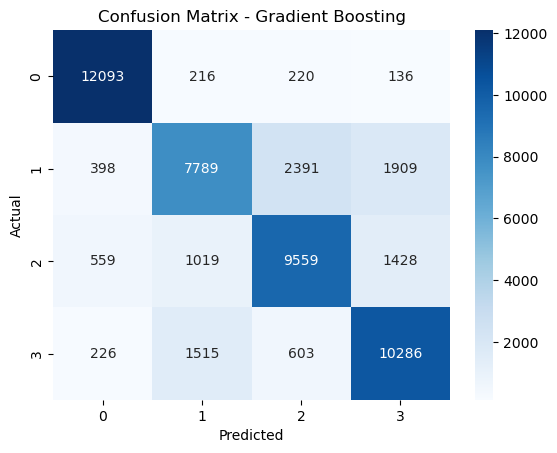

In [ ]:
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

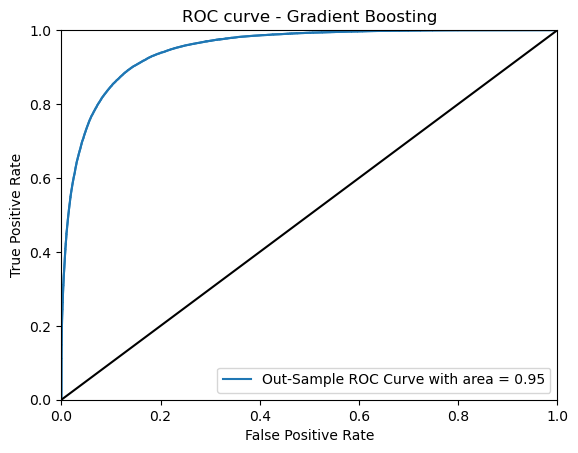

In [ ]:
y_test_binarized = label_binarize(y_test, classes=xgb_classifier.classes_) # Binarize the labels
y_pred_proba = xgb_classifier.predict_proba(X_test) # Get probabilities for each class


(fpr, tpr, thresholds) = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())

area = auc(fpr,tpr)
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area, color='tab:blue')
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()